## 1. Setup and Imports

In [1]:
!pip install neo4j pandas numpy matplotlib seaborn

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

### Connect to Neo4j

**⚠️ Update the password below to match your Neo4j instance!**

In [3]:
# Neo4j connection parameters
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "JeanAlice#123"  # CHANGE THIS!

# Test connection
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

try:
    with driver.session() as session:
        result = session.run("RETURN 'Connected to Neo4j!' AS message")
        print(result.single()["message"])
        print("✓ Connection successful!")
except Exception as e:
    print(f"✗ Connection failed: {e}")
    print("Make sure Neo4j is running: docker ps or using local command(To be specify) if not working with docker")

✗ Connection failed: Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687',)):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused)
Make sure Neo4j is running: docker ps or using local command(To be specify) if not working with docker


## 2. Understanding the dataset

In [4]:
# Load the CSV files
data_path =''
movies_df = pd.read_csv(os.path.join(data_path, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(data_path, "ratings.csv"))

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Number of users: {ratings_df['userId'].nunique():,}")
print(f"Number of movies: {movies_df.shape[0]:,}")
print(f"Number of ratings: {ratings_df.shape[0]:,}")
print(f"\nRating range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Median rating: {ratings_df['rating'].median():.1f}")

DATASET OVERVIEW
Number of users: 671
Number of movies: 9,125
Number of ratings: 100,004

Rating range: 0.5 - 5.0
Average rating: 3.54
Median rating: 4.0


In [5]:
# Preview the data
print("\n" + "="*60)
print("MOVIES SAMPLE")
print("="*60)
display(movies_df.head(10))

print("\n" + "="*60)
print("RATINGS SAMPLE")
print("="*60)
display(ratings_df.head(10))


MOVIES SAMPLE


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller



RATINGS SAMPLE


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


## 3.Exploratory data analysis

We have 9125 movies
Number of duplicated movies :0
Number of missing values in the movies data :
movieId    0
title      0
genres     0
dtype: int64
Distribution of the movies genres
Total Numbers of genres : 20
genres_list
Drama                 4365
Comedy                3315
Thriller              1729
Action                1545
Romance               1545
Adventure             1117
Crime                 1100
Horror                 877
Sci-Fi                 792
Fantasy                654
Children               583
Mystery                543
Documentary            495
Animation              447
Musical                394
War                    367
Western                168
IMAX                   153
Film-Noir              133
(no genres listed)      18
Name: count, dtype: int64
Multigenders movies
   n_genres  percentage
7         1       30.61
8         2       33.30
6         3       23.18
5         4        9.34
4         5        2.86
3         6        0.55
2         7        0.1

/tmp/ipykernel_80625/4034258553.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = 'genre', x = 'count', data = genre_df, palette = 'crest')
/tmp/ipykernel_80625/4034258553.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n_genres', y = 'percentage', data = dist_df, palette = 'viridis')


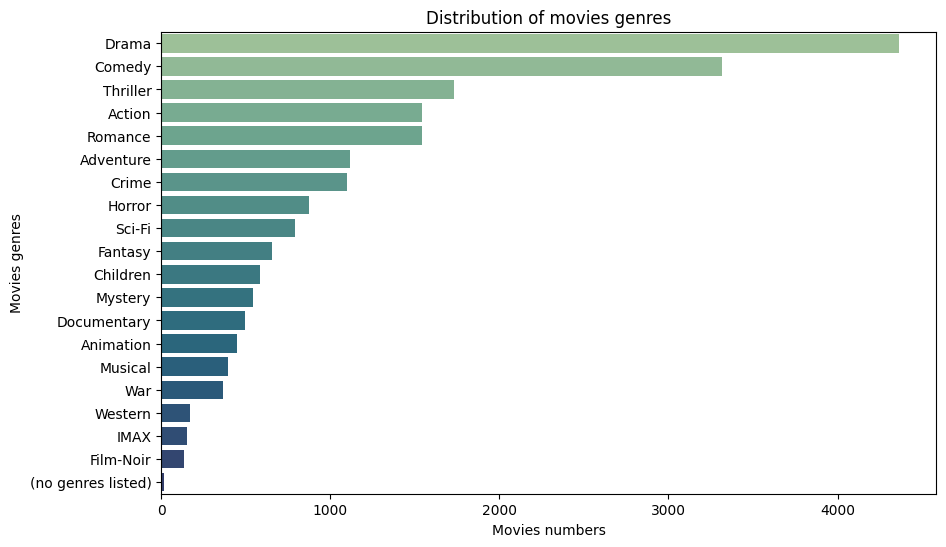

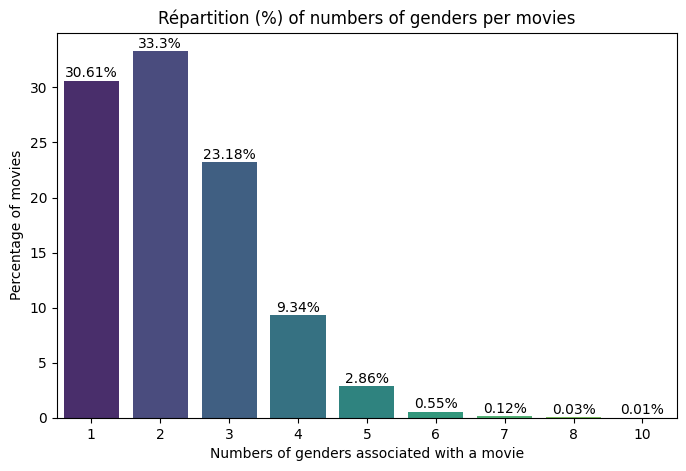

 Average numbers of genders per movie : 2.2290410958904108
 Maximum of genders for a movie : 10
Minimum of genders for a movie : 1


In [6]:
# Movies 
print ( "We have 9125 movies")
print (f"Number of duplicated movies :{movies_df.duplicated(subset = ['movieId', 'title', 'genres']).sum()}")
print (f"Number of missing values in the movies data :")
print (f"{movies_df.isnull().sum()}")
print("Distribution of the movies genres")
movies_df['genres_list'] = movies_df['genres'].apply(lambda x:x.split('|') if isinstance(x, str) else [])
genres_exploded =  movies_df.explode('genres_list')
genre_counts = genres_exploded['genres_list'].value_counts()

flat_genres = [genre for sublist in movies_df['genres_list'] for genre in sublist]
uniques_genre = set(flat_genres)
print(f"Total Numbers of genres : {len(uniques_genre)}")
# Numbers of movies for each genres
print(genre_counts)

# Visualization of the genres
genre_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values('count', ascending = False ) 
plt.figure(figsize = (10,6))
sns.barplot(y = 'genre', x = 'count', data = genre_df, palette = 'crest')
plt.title("Distribution of movies genres")
plt.xlabel("Movies numbers")
plt.ylabel("Movies genres")
plt.show


## Multigenders movies 
print ('='*20)
print ("Multigenders movies")
print ('='*20)
movies_df['n_genres'] = movies_df['genres_list'].apply(len)
dist = movies_df['n_genres'].value_counts().sort_values()
dist_percent = (dist / dist.sum() * 100).round(2)
dist_df = pd.DataFrame({
    'n_genres':dist.index,
    'percentage': dist_percent.values
}).sort_values('n_genres')
print(dist_df)
plt.figure(figsize=(8,5))
sns.barplot(x='n_genres', y = 'percentage', data = dist_df, palette = 'viridis')
plt.title("Répartition (%) of numbers of genders per movies")
plt.xlabel("Numbers of genders associated with a movie")
plt.ylabel("Percentage of movies")
# Adding of values on the bars
for idx, row in enumerate(dist_df.itertuples()):
    plt.text(idx, row.percentage + 0.3 , f"{row.percentage}%", ha = 'center')
plt.show()

print(" Average numbers of genders per movie :", movies_df['n_genres'].mean())
print(" Maximum of genders for a movie :", movies_df['n_genres'].max())
print("Minimum of genders for a movie :", movies_df['n_genres'].min())

In [ ]:
# Users & Ratings
print ('='*60)
print('          Users & Ratings')
print('='*60)
print ("We have 100,004 ratings for 671 users")

print(f"Numbers of missing values : {ratings_df.isnull().sum()}")

print(f" Average numbers of ratings per user : {ratings_df.groupby('userId')['rating'].count().mean()}")
print(" Maximum of rating for a user :", ratings_df.groupby('userId')['rating'].count().max())
print("Minimum of rating for a user :", ratings_df.groupby('userId')['rating'].count().min())
print("Median of rating for a user :", ratings_df.groupby('userId')['rating'].count().median())
print('50% of users rated less than 71 movies and 50% of users rated more than 71 movies')

# checking that the rating is unique for each user , each user rate a movie only once 
print("Checking that each user rates a movie only once")
unique_couples = ratings_df[['userId', 'movieId']].drop_duplicates().shape[0]
print(f"Numbers of unique couple (userId, movieId) : {unique_couples}")

# Distribution of ratings
rating_distribution = ratings_df['rating'].value_counts().sort_index()
rating_percent = ( rating_distribution / rating_distribution.sum() * 100 ).round(2)
rating_distribution_df = pd.DataFrame({
    'rating' :rating_distribution.index,
    'count': rating_distribution.values,
    'percentage': rating_percent.values
})
# vizualisation
plt.figure(figsize=(10,6))
sns.barplot(x='rating', y = 'percentage', data = rating_distribution_df, hue = 'rating', palette = 'viridis')
plt.title("Distribution of ratings ")
# Adding the percentage on the bar
for idx, row in enumerate(rating_distribution_df.itertuples()):
    plt.text(idx, row.count + 0.5, f"{row.percentage}%", ha='center')
plt.show()

          Users & Ratings
We have 100,004 ratings for 671 users
Numbers of missing values : userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
 Average numbers of ratings per user : 149.03725782414307
 Maximum of rating for a user : 2391
Minimum of rating for a user : 20
Median of rating for a user : 71.0
50% of users rated less than 71 movies and 50% of users rated more than 71 movies
Checking that each user rates a movie only once
Numbers of unique couple (userId, movieId) : 100004


/tmp/ipykernel_80625/1560309986.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y = 'percentage', data = rating_distribution_df, palette = 'viridis')


## 4. Loading Data into Neo4j

Now we will create the graph structure in Neo4j.

In [23]:
def clear_database():
    """Clear all nodes and relationships"""
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    print("✓ Database cleared")

def create_constraints():
    """Create uniqueness constraints for better performance"""
    with driver.session() as session:
        try:
            session.run("CREATE CONSTRAINT user_id IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE")
            session.run("CREATE CONSTRAINT movie_id IF NOT EXISTS FOR (m:Movie) REQUIRE m.movieId IS UNIQUE")
            print("✓ Constraints created")
        except Exception as e:
            print(f"Constraints may already exist: {e}")

# Clear and prepare database
clear_database()
create_constraints()

✓ Database cleared
✓ Constraints created


In [24]:
# Load movies
print("Loading movies...")
with driver.session() as session:
    for _, row in movies_df.iterrows():
        session.run("""
            MERGE (m:Movie {movieId: $movieId})
            SET m.title = $title, m.genres = $genres
        """, movieId=int(row['movieId']), 
             title=row['title'], 
             genres=row['genres'])

print(f"✓ Loaded {len(movies_df)} movies")

Loading movies...
✓ Loaded 9125 movies


In [25]:
# Load ratings in batches
print("Loading ratings...")
batch_size = 1000

for i in range(0, len(ratings_df), batch_size):
    batch = ratings_df.iloc[i:i+batch_size]
    
    with driver.session() as session:
        session.run("""
            UNWIND $ratings AS rating
            MERGE (u:User {userId: rating.userId})
            MERGE (m:Movie {movieId: rating.movieId})
            MERGE (u)-[r:RATED]->(m)
            SET r.rating = rating.rating, r.timestamp = rating.timestamp
        """, ratings=[row.to_dict() for _, row in batch.iterrows()])
    
    if (i + batch_size) % 10000 == 0:
        print(f"  Loaded {i + batch_size:,} ratings...")

print(f"✓ Loaded {len(ratings_df):,} ratings")
print("\n✓ Data loading complete!")

Loading ratings...
  Loaded 10,000 ratings...
  Loaded 20,000 ratings...
  Loaded 30,000 ratings...
  Loaded 40,000 ratings...
  Loaded 50,000 ratings...
  Loaded 60,000 ratings...
  Loaded 70,000 ratings...
  Loaded 80,000 ratings...
  Loaded 90,000 ratings...
  Loaded 100,000 ratings...
✓ Loaded 100,004 ratings

✓ Data loading complete!


In [27]:
# Verify data in Neo4j
with driver.session() as session:
    result = session.run("MATCH (u:User) RETURN count(u) AS count")
    user_count = result.single()["count"]
    
    result = session.run("MATCH (m:Movie) RETURN count(m) AS count")
    movie_count = result.single()["count"]
    
    result = session.run("MATCH ()-[r:RATED]->() RETURN count(r) AS count")
    rating_count = result.single()["count"]

print("="*60)
print("NEO4J DATABASE STATISTICS")
print("="*60)
print(f"Users in database: {user_count:,}")
print(f"Movies in database: {movie_count:,}")
print(f"Ratings in database: {rating_count:,}")
print("\n✓ Data successfully loaded into Neo4j!")

NEO4J DATABASE STATISTICS
Users in database: 671
Movies in database: 9,125
Ratings in database: 100,004

✓ Data successfully loaded into Neo4j!


In [28]:
# Try to get few data
with driver.session() as session:
    result = session.run("MATCH (n:Movie) RETURN n LIMIT 5")
    
    # Print the results
    for record in result:
        print(record["n"])

<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:0' labels=frozenset({'Movie'}) properties={'genres': 'Adventure|Animation|Children|Comedy|Fantasy', 'movieId': 1, 'title': 'Toy Story (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:1' labels=frozenset({'Movie'}) properties={'genres': 'Adventure|Children|Fantasy', 'movieId': 2, 'title': 'Jumanji (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:2' labels=frozenset({'Movie'}) properties={'genres': 'Comedy|Romance', 'movieId': 3, 'title': 'Grumpier Old Men (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:3' labels=frozenset({'Movie'}) properties={'genres': 'Comedy|Drama|Romance', 'movieId': 4, 'title': 'Waiting to Exhale (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:4' labels=frozenset({'Movie'}) properties={'genres': 'Comedy', 'movieId': 5, 'title': 'Father of the Bride Part II (1995)'}>


In [29]:
# Try to get few data
with driver.session() as session:
    result = session.run("MATCH (n:Movie) RETURN n LIMIT 3")
    
    for record in result:
        movie = record["n"]
        print(f"Movie ID: {movie['movieId']}, Title: {movie['title']}")

Movie ID: 1, Title: Toy Story (1995)
Movie ID: 2, Title: Jumanji (1995)
Movie ID: 3, Title: Grumpier Old Men (1995)


## 5. Recommandation System